# BAIS 6040 Data Programming in Python

## Spring 2021

## Group 3 Project

## Data Cleaning and Sorting

### Jared Barkley, Tyler Zaruba, Netaji Boggarapu, Michael Noonan

## Data Sources

Our group project looked at Covid case data for at the county level in Minnesota to study if there were any links between the rate of Covid cases in each county and various geospatial factors may be identified which correlate with higher rates of infection or death.  We collected data which contained many data points for each county, such as the population, mean household size, number of long-term care facilities in each county, number of cases attributed to long-term care facilities in each county, and total population in congregate living in each county.

The sources for our data were primarily the Minnesota Department of Health and Minnesota State Demographic Center.  From the Minnesota Department of Health we were able to obtain the case counts and total death counts per county.  We were also able to obtain the number of cases attributed to each individual nursing home facilities in the state.  This data was aggregated by county to obtain a count of Covid cases attributable to nursing home facilities, as well as a count of long term care facilities in each county.  From the Minnesota State Demographic Center, we were able to obtain the population of each county, which was then compiled with the case data to obtain infection rates and death rates for each county.  Population density was the one piece of data which we were not able to obtain in a downloadable format, and so this data was added manually in excel using values obtained from usa.com.

Cases, deaths and no longer needing isolation by County of Residence (County Cases Raw)
https://www.health.state.mn.us/diseases/coronavirus/stats/index.html#wtrmap1

Congregate Care Facilities with Exposures, by County (FacilityData Raw)
https://www.health.state.mn.us/diseases/coronavirus/situation.html#ccf1

County Population Data (Countypopulationraw)
https://mn.gov/admin/demography/data-by-topic/population-data/our-estimates/

Population Density by County
http://www.usa.com/rank/minnesota-state--population-density--county-rank.htm?hl=&hlst=&wist=&yr=&dis=&sb=DESC&plow=&phigh=&ps=

## Import Libraries and Data

In [743]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

In [744]:
#Import raw data for total cases by county, and breakdown of cases per facility

countycases_dir = "https://raw.githubusercontent.com/jaredbarkley0/PythonGroupProject/master/Cases%20by%20MN%20Counties.csv"
countyfacilities_dir = "https://raw.githubusercontent.com/jaredbarkley0/PythonGroupProject/master/MN%20Cases%20By%20Care%20Facility.csv"
countypopulations_dir = "https://raw.githubusercontent.com/jaredbarkley0/PythonGroupProject/master/mn_county_estimates_sdc_2019_tcm36-442553.xlsx"

## Clean base county case data

In [745]:
#Read County Case data
countycasesraw = pd.read_csv(countycases_dir)
# countycasesraw

In [746]:
#Check dataframe info
# countycasesraw.info()

In [747]:
# Reformatting "Pop Density" column into a float value so we can calculate off of it
# Use .strip method on string to remove '/sq mi' and then convert to float

countycasesraw['Pop Density'] = countycasesraw['Pop Density'].astype(str).map(lambda x: x.strip('/sq mi')).astype(float)
# countycasesraw

# Clean Nursing Home Data

In [748]:
# read facility data

facilitydataraw = pd.read_csv(countyfacilities_dir)
# facilitydataraw

In [749]:
#Create a Groupby Object for Raw Facilities Data

facilitygrouper = facilitydataraw[['Name of Facility','County','Total confirmed cases in facility']].groupby('County')

# Count number of facilities in each county
countyfacilitytally = facilitygrouper['Name of Facility'].agg(NursingHomeCount = 'count')
# countyfacilitytally

In [750]:
# Sum number of cases per facility in each county
countyfacilitycases = facilitygrouper['Total confirmed cases in facility'].agg(NursingHomeCaseCount = 'sum')
# countyfacilitycases

In [751]:
# Combine cases by facility and facility count per county into one dataframe

compiledfacilitydata = pd.concat([countyfacilitycases,countyfacilitytally], axis=1)

#compiledcountydata['Compare County'] = compiledcountydata.index
# compiledfacilitydata

In [752]:
# tests on number of counties in each dataframe
len(countycasesraw['County'])

88

In [753]:
# test number of counties
len(compiledfacilitydata.index)

86

# Clean Population Data

In [754]:
# read population data
countypopulationsraw = pd.read_excel(countypopulations_dir)
# countypopulationsraw

In [755]:
#Check info
# countypopulationsraw.info()

In [756]:
#Drop "Unassigned" County
countypopulationsraw.dropna(inplace = True)
# countypopulationsraw.info()

In [757]:
#Convert 'object' type population to integer
def column_to_numeric(data, column):
    data[column] = pd.to_numeric(data[column])

column_to_numeric(countypopulationsraw, 'Total Population, 2019')
column_to_numeric(countypopulationsraw, 'Population in Group Quarters, 2019')
# countypopulationsraw.info()

In [758]:
# Drop unused columns
countypopulationsraw.drop(['County Code','Population in Households, 2019','Households, 2019'],axis = 1, inplace=True)

# Combine Dataframes

In [759]:
# Define function for creating new columns that are divdends from existing

def quotientcol(dataframe, newcol, dividendcol, divisorcol):
    dataframe[newcol] = dataframe[dividendcol]/dataframe[divisorcol]

In [760]:
# merge dataframes, how = outer so that data is not lost for rows with NaN values

countycasesandfacilities = countycasesraw.merge(compiledfacilitydata, left_on='County', right_on='County', how = 'outer')
combinedcountydata = countycasesandfacilities.merge(countypopulationsraw, left_on='County', right_on='County Name', how = 'outer')

# Rename multiple columns in place to more intuitive names
combinedcountydata.rename(columns = {'NursingHomeCount':'No. of Nursing Homes in County',
                                     'NursingHomeCaseCount':'No. of Cases in Nursing Homes',
                                    'Total Population, 2019':'Population',
                                    'Persons per Household, 2019':'Mean Household Size',
                                    'Population in Group Quarters, 2019':'Congregate Living Population'}, inplace = True)

# Create aggregate columns from combined data
quotientcol(combinedcountydata, 'Rate of Infection', 'Total Positive Cases', 'Population')
quotientcol(combinedcountydata, 'Nursing Home Cases, % of Total', 'No. of Cases in Nursing Homes', 'Total Positive Cases')
quotientcol(combinedcountydata, 'Cases per number of Nursing Homes','No. of Cases in Nursing Homes','No. of Nursing Homes in County')
quotientcol(combinedcountydata, 'Death Rate', 'Total Positive Cases','Total Deaths')

# Check info for final dataframe
# combinedcountydata.info()

In [761]:
# Identify Rows with NaN values
combinedcountydata[combinedcountydata.isna().any(axis=1)]

,County,Total Positive Cases,Total Deaths,Total No Longer Needing Isolation,Pop Density,No. of Cases in Nursing Homes,No. of Nursing Homes in County,County Name,Population,Congregate Living Population,Mean Household Size,Rate of Infection,"Nursing Home Cases, % of Total",Cases per number of Nursing Homes,Death Rate
15,Cook,118,0,118,1.6,NaN,NaN,Cook,5462.0,49.0,1.999631,0.021604,NaN,NaN,NaN
87,Unknown/Missing,444,0,437,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [762]:
# Cook County has multiple NaN values in columns related to nursing homes because Cook County has no nursing homes
# We would like to preserve data for Cook County in our analysis, so we will fill in NaN and inf values in columns related to nursing homes
pd.set_option('mode.use_inf_as_na', True)
fillfacilitiesdata = {'No. of Cases in Nursing Homes':0,'No. of Nursing Homes in County':0,'Nursing Home Cases, % of Total':0,
                      'Cases per number of Nursing Homes':0, 'Death Rate':0}
combinedcountydata.fillna(fillfacilitiesdata, inplace=True)

In [763]:
# Spot Check Cook County
# combinedcountydata.iloc[15]

In [764]:
# Check again for Rows with NaN values
combinedcountydata[combinedcountydata.isna().any(axis=1)]

,County,Total Positive Cases,Total Deaths,Total No Longer Needing Isolation,Pop Density,No. of Cases in Nursing Homes,No. of Nursing Homes in County,County Name,Population,Congregate Living Population,Mean Household Size,Rate of Infection,"Nursing Home Cases, % of Total",Cases per number of Nursing Homes,Death Rate
87,Unknown/Missing,444,0,437,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0


In [765]:
#Unknown/unassigned county cases are not relevant to our analysis, they may be removed
#Drop NA values (unassigned/unknown County Data)
combinedcountydata.dropna(inplace=True)

In [766]:
# Verify no non-null values remain in dataframe
# combinedcountydata.info()

In [767]:
#Minnesota has 87 counties, and our data frame has 87 entries for each column
#Reorder columns
finalcountydata = combinedcountydata.reindex(columns=['County','Total Positive Cases','Total Deaths','Population',
                                                      'Rate of Infection','Death Rate','Pop Density','Mean Household Size',
                                                      'Congregate Living Population','No. of Cases in Nursing Homes',
                                                      'No. of Nursing Homes in County','Nursing Home Cases, % of Total',
                                                     'Cases per number of Nursing Homes'])
finalcountydata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87 entries, 0 to 86
Data columns (total 13 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   County                             87 non-null     object 
 1   Total Positive Cases               87 non-null     int64  
 2   Total Deaths                       87 non-null     int64  
 3   Population                         87 non-null     float64
 4   Rate of Infection                  87 non-null     float64
 5   Death Rate                         87 non-null     float64
 6   Pop Density                        87 non-null     float64
 7   Mean Household Size                87 non-null     float64
 8   Congregate Living Population       87 non-null     float64
 9   No. of Cases in Nursing Homes      87 non-null     float64
 10  No. of Nursing Homes in County     87 non-null     float64
 11  Nursing Home Cases, % of Total     87 non-null     float64
 

In [768]:
# Export dataframe as csv
# finalcountydata.to_csv("MN County Data_032721.csv")

In [769]:
columns = ["Total Positive Cases","Population", "Rate of Infection", "Congregate Living Population","No. of Cases in Nursing Homes","No. of Nursing Homes in County",'Cases per number of Nursing Homes']
target = "Total Deaths"

X = finalcountydata[columns]
y = finalcountydata[target]

In [770]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [771]:
X_Plot = X["Population"]
X_Plot

0      15870.0
1     362648.0
2      34545.0
3      47184.0
4      40895.0
        ...   
82     10923.0
83      6226.0
84     50830.0
85    138531.0
86      9729.0
Name: Population, Length: 87, dtype: float64

In [772]:
#assign a variable to call linear regression function
lr = LinearRegression(fit_intercept=False)
lr

LinearRegression(fit_intercept=False)

In [773]:
lr.fit(X_train, y_train)

LinearRegression(fit_intercept=False)

In [774]:
lr.score(X_train, y_train)

0.985579136742596

In [775]:
lr.score(X_test, y_test)

0.9868321720845543

In [776]:
import math
from sklearn.metrics import explained_variance_score, mean_absolute_error, r2_score, mean_squared_error

def printMetrics(test, predictions):
    print(f"Score: {explained_variance_score(test, predictions):.2f}")
    print(f"Mean Absolute Error: {mean_absolute_error(test, predictions):.2f}")
    print(f"Mean Squared Error: {math.sqrt(mean_squared_error(test, predictions)):.2f}")
    print(f"r2: {r2_score(test, predictions):.2f}")
    print(f"Reg Fit: {lr.score(X_test, y_test):.2f}")

In [777]:
predictions = lr.predict(X_test)
printMetrics(y_test, predictions)

Score: 0.99
Mean Absolute Error: 17.70
Mean Squared Error: 40.82
r2: 0.99
Reg Fit: 0.99


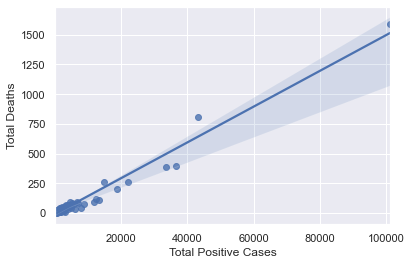

In [778]:
sns.set_theme(color_codes=True)
sns.regplot(x="Total Positive Cases", y="Total Deaths", data=finalcountydata);

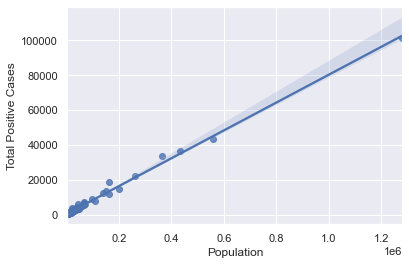

In [779]:
sns.set_theme(color_codes=True)
sns.regplot(x="Population", y="Total Positive Cases",  data=finalcountydata);

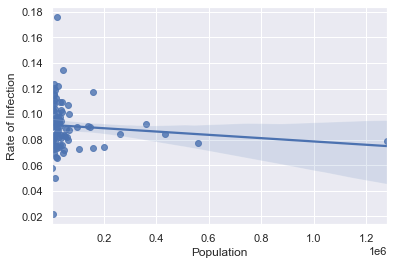

In [780]:
sns.set_theme(color_codes=True)
sns.regplot(x="Population", y="Rate of Infection", data=finalcountydata);

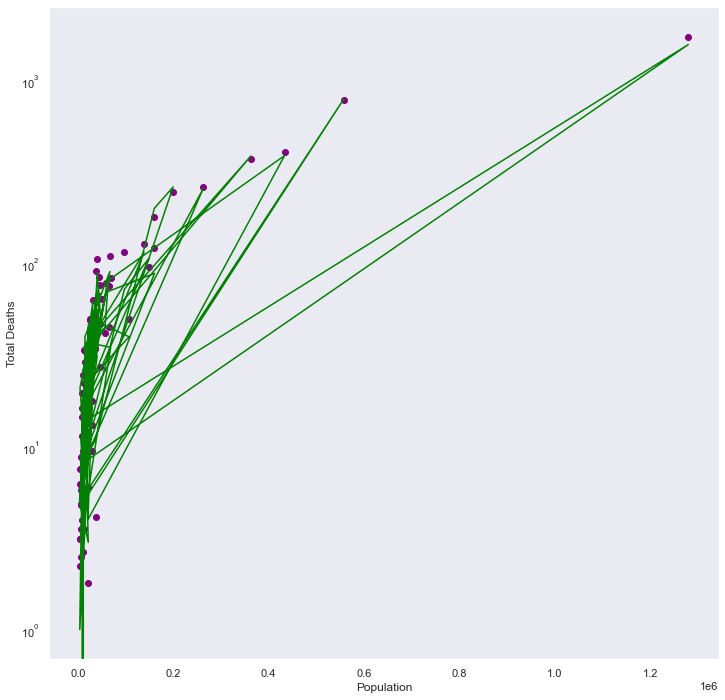

In [781]:
fig, ax = plt.subplots(figsize=(12,12))
y_pred = lr.predict(X)
plt.scatter(X_Plot, y_pred, color='purple')
plt.plot(finalcountydata["Population"],finalcountydata["Total Deaths"], color='green')
plt.yscale("log")
plt.grid(False)
plt.xlabel("Population")
plt.ylabel("Total Deaths")
plt.show()

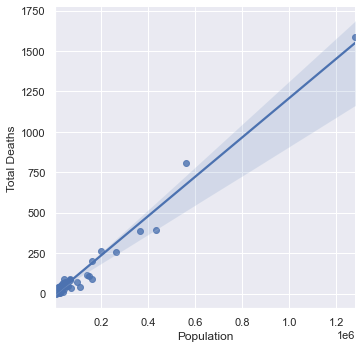

In [782]:
sns.lmplot(x="Population", y="Total Deaths", data=finalcountydata);

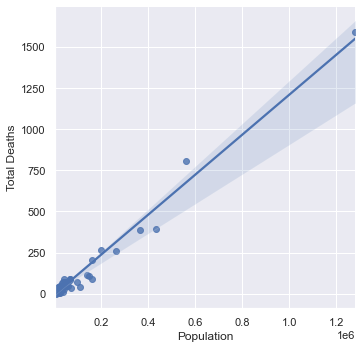

In [783]:
sns.lmplot(x="Population", y="Total Deaths", data=finalcountydata);

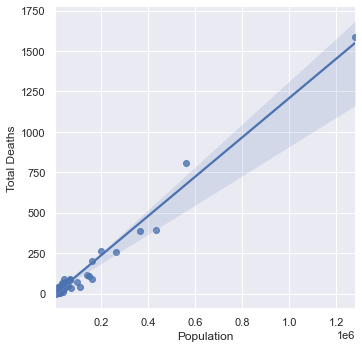

In [784]:
sns.lmplot(x="Population", y="Total Deaths", data=finalcountydata,  x_jitter=.05);

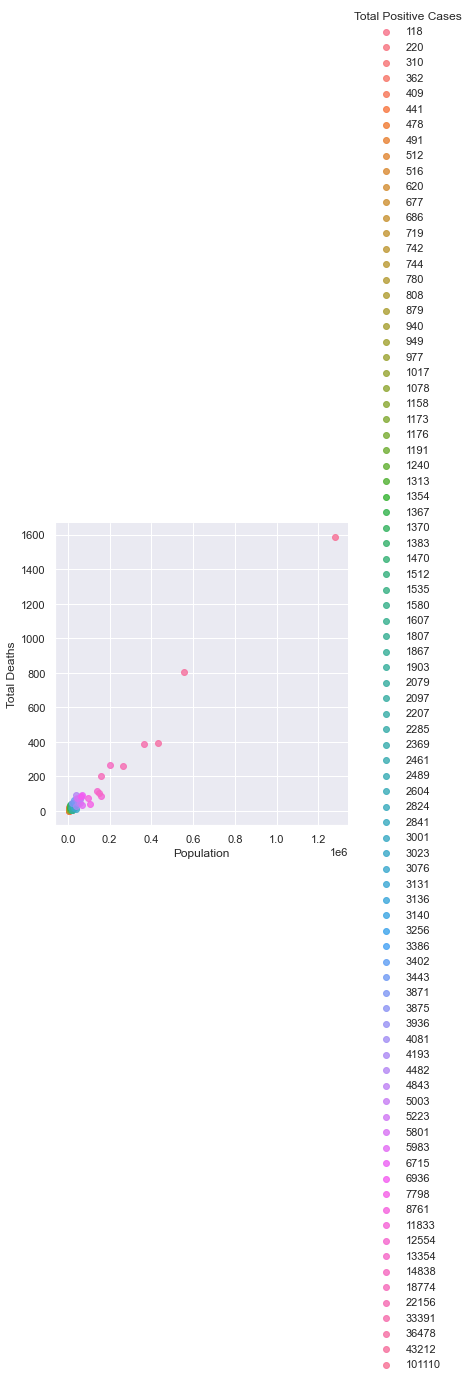

In [785]:
sns.lmplot(x="Population", y="Total Deaths", hue="Total Positive Cases", data=finalcountydata,  x_jitter=.05);

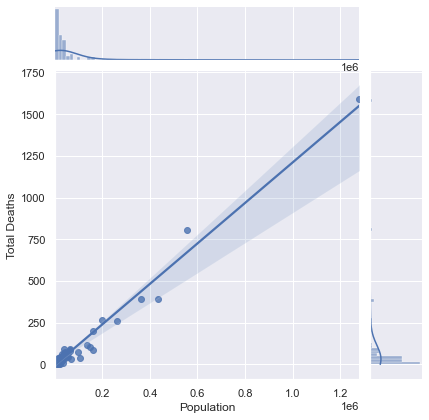

In [786]:
sns.jointplot(x="Population", y="Total Deaths", data=finalcountydata, kind="reg");
